# Bias-Variance Analysis

## Initialization and bootstrapping functions

In [9]:
# reading the data
read_data <- function(data,sc) {
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}


# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=50){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

## stochastic gradient algorithm

In [2]:
# to prevent displaying the warning info
options(warn=-1)

# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi %*% as.matrix(w))
} 

# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 reg ulariser is already included in the objective function for training 
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

################################################################

# stochatic gradient training function
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
   
   # train length
    train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len
   
   # coefficient matric
   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
   
    # loop
   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(W[tau-1,])
}


# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # modified to fit L2 regularization
   grad = - (y_true-y_pred) * x 
   return(W_prev - eta * (2*grad + 2* lambda* W_prev))
}

################################################################

## Reading the data from file and initializing Final ouput dataframe 

In [3]:
options(warn =-1)

# reading test and train data
train2 = read.csv("Task2B_train.csv",header=TRUE)
test2 = read.csv("Task2B_test.csv",header=TRUE)

# initializing all lambda values
lambda= as.vector(seq(0, 5, by = 0.2))
M = length(lambda)

# output of stochastic algorithm test prediction
y <- data.frame(matrix(0,nrow=L*M, ncol=nrow(test2)+2))
names(y) <- c('m', 'l',  paste('y',1:nrow(test2), sep=''))
y$m <- rep(lambda, 1, each = L)
y$l <- rep(1:50, length(lambda), each = 1)

## Main function to get the predictions of every model

In [4]:
options(warn =-1)
N = 100 # number of datapoints in a sample
L = 50 # number of samples

# scaled test data
dtest <- read_data(test2,TRUE)

# to train stochastic gradient algorithm with differnt lambda with different train data
play_with_sgd <- function() {
    
# bootstrapping train data
boot.indx <- boot(nrow(train2), N, L)

# iteration on every boot sample
for (j in 1:nrow(boot.indx)){
    # for each index
    indx <- as.numeric(boot.indx[j,])
    # new train data
    train.data <- train2[indx,]
    rownames(train.data) <- NULL 
    # scaled train data
    dtrain <- read_data(train.data,TRUE)
  # for each lambda
  for(k in lambda){
        max_epoch = 20
        epsilon = .001
        eta = .01
        # final weight vector
        W = sgd_train(dtrain$x, dtrain$y, k, eta, epsilon, max_epoch)
        # prediction of test label
        test_errors = predict_func(dtest$x, W)
        y[y$m==k & y$l==j, -c(1,2)] <- test_errors
}
    }
    # returning all predictions for different lambda and different dataset
    return(y)
}

# call the function
Y <- play_with_sgd()

## Calculating Bias2, variance, and error

In [6]:
# aggregating the predicted values
y.bar <- aggregate(Y, list(Y$m),mean)
y.bar <- as.matrix(y.bar[,-c(1:3)])

# intializing bias2,variance and error matrices
error <- matrix(0,nrow=M)
bias2 <- matrix(0,nrow=M)
variance <- matrix(0,nrow=M)

i <- 1
# for each lambda
for (m in lambda){
    bias2[i] <- mean((y.bar[i,] - dtest$y)^2)
    variance[i] <- mean((Y[Y$m==m,-c(1,2)]-y.bar[i,])^2)
    error[i] <- mean((Y[Y$m==m,-c(1,2)]-dtest$y)^2)
    i <- i + 1
}

## Plotting the bias2, variance, error and bias2+variance against ln(lambda)

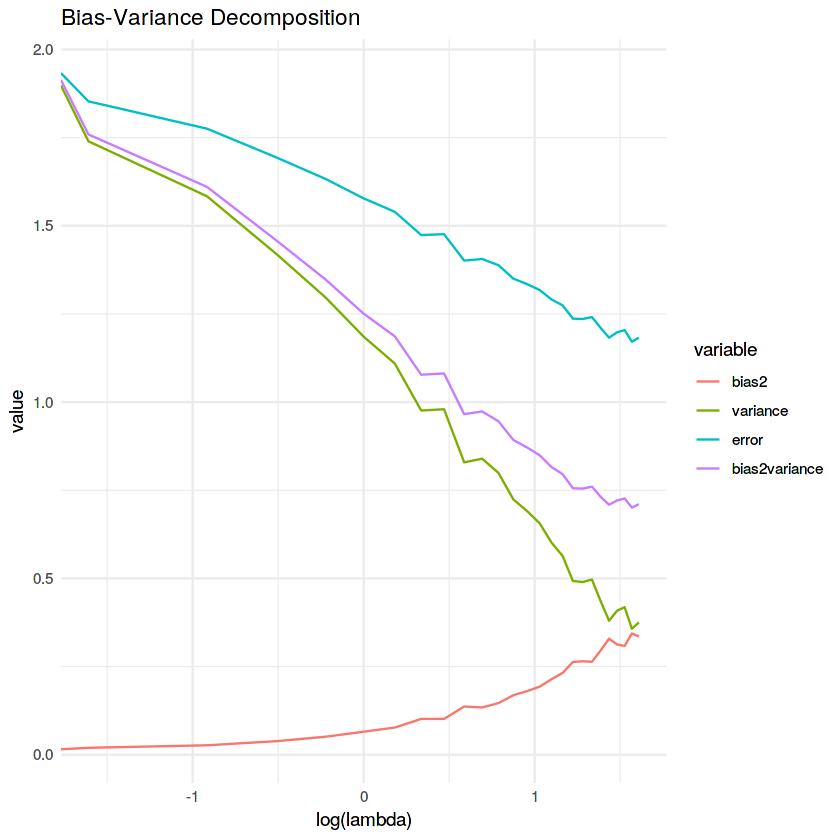

In [7]:
# using ggplots and reshapes
library(ggplot2)
library(reshape2)
dat <- as.data.frame(cbind(lambda, bias2=bias2, variance, error, bias2+variance))
names(dat) <- c('lambda', 'bias2', 'variance', 'error', 'bias2variance')
dat.m <- melt(dat, id='lambda')

# plotting the graph
ggplot(data=dat.m, aes(x=log(lambda), y=value, color=variable)) + geom_line() + 
        labs(title='Bias-Variance Decomposition') +  theme_minimal()

The best lambda would be **5** or more than 5 since, that the point bias and variance is intersecting